### Sample program to create embeddings using 'gensim'

<!-- ```py
from gensim.models import Word2Vec

# Sample sentences
sentences = [
    ['this', 'is', 'a', 'sample', 'sentence'],
    ['another', 'example', 'sentence'],
    ['yet', 'another', 'sentence'],
    ['one', 'more', 'example'],
    ['one', 'more', 'examples'],
]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=100, min_count=1, workers=4)

# Get the embedding vector for a word
word_embedding = model.wv['examples']
print("Embedding for 'examples':", word_embedding[:4])

# Find similar words
similar_words = model.wv.most_similar('example', topn=3)
print("Similar words to 'example':", similar_words)

model.wv.key_to_index.keys()
``` -->

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [2]:
# Creating random data with there embedings

import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from faker import Faker

dummy_data_genrator = Faker()
data_volume = 1_000

In [3]:
payload_data = []

for r in range(data_volume):
    payload_data.append(
        {
            "name":dummy_data_genrator.name(),
            "address":dummy_data_genrator.address(),
            "country":dummy_data_genrator.country(),
            "url":dummy_data_genrator.url(),
            "year":dummy_data_genrator.year(),
            "color":dummy_data_genrator.color()
        }
    )

In [4]:
df = pd.DataFrame(payload_data)
df.head(2)

,name,address,country,url,year,color
0,Paul Wilson,"541 Sawyer Hills Apt. 549\nSharonbury, MD 03559",Seychelles,http://www.rodriguez.org/,2016,#e9f473
1,Alexis Kidd,"563 Miller Heights\nJohnsonmouth, CA 05548",Cambodia,http://www.duffy.com/,2010,#5bf94f


In [5]:
extracted_country_data = [[data['country'], data['year']] for index, data in df.iterrows()]
extracted_country_data[:3]

[['Seychelles', '2016'], ['Cambodia', '2010'], ['Belize', '2002']]

In [6]:
# Train Word2Vec model
# Adjust parameters like vector_size (dimensionality of the embeddings), window (context window size), and min_count (minimum frequency of words) based on your dataset and requirements.
# Use meaningful variable names for better readability and maintainability.
vector_size = 100  # Dimensionality of the embeddings
window = 5  # Context window size
min_count = 1  # Minimum frequency of words
workers = 4  # Number of worker threads to train the model
model = Word2Vec(extracted_country_data, vector_size=vector_size, window=window, min_count=min_count, workers=workers)

2024-03-20 23:16:13,136 : INFO : collecting all words and their counts
2024-03-20 23:16:13,138 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-20 23:16:13,141 : INFO : collected 293 word types from a corpus of 2000 raw words and 1000 sentences
2024-03-20 23:16:13,143 : INFO : Creating a fresh vocabulary
2024-03-20 23:16:13,147 : DEBUG : starting a new internal lifecycle event log for Word2Vec
2024-03-20 23:16:13,148 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 293 unique words (100.00% of original 293, drops 0)', 'datetime': '2024-03-20T23:16:13.147945', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
2024-03-20 23:16:13,149 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2000 word corpus (100.00% of original 2000, drops 0)', 'datetime': '2024-03-20T23:16:13.149946', 'ge

In [7]:
# Get keys (words) from the Word2Vec model
list(model.wv.key_to_index.keys())[:3]

['2004', '1984', '2005']

In [8]:
# Get embeddings for each user
country_embeddings = []
year_embeddings = []
for idx, row in df.iterrows():
    country = row['country']
    year = row['year']
    country_embeddings.append(model.wv[str(country)])
    year_embeddings.append(model.wv[str(year)])
country_embeddings[1][:2], year_embeddings[1][:2]


(array([0.00333445, 0.00427895], dtype=float32),
 array([0.00209961, 0.00576099], dtype=float32))

In [9]:
len(country_embeddings), len(year_embeddings), len(payload_data)

(1000, 1000, 1000)

### Storing embeddings in vector database

In [10]:
from utilities import get_key

from qdrant_client import QdrantClient
from qdrant_client.http import models

client = QdrantClient(
    url=get_key("QDRANT_URL"),
    api_key=get_key("QDRANT_KEY"),
)
client

2024-03-20 23:16:22,562 : DEBUG : load_ssl_context verify=True cert=None trust_env=True http2=False
2024-03-20 23:16:22,567 : DEBUG : load_verify_locations capath='c:\\Users\\satya\\.vscode\\extensions\\ukoloff.win-ca-3.5.1\\node_modules\\win-ca\\pem'


In [11]:
country_collection_name = "test_collection_country"
year_collection_name = "test_collection_year"
index = list(range(data_volume))
country_collection_name,year_collection_name, index[:3], len(index)

('test_collection_country', 'test_collection_year', [0, 1, 2], 1000)

In [12]:
try:
    client.create_collection(
        collection_name=year_collection_name,
        vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
    )
    client.create_collection(
        collection_name=country_collection_name,
        vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
    )
except Exception as ex:
    print(ex)

2024-03-20 23:16:24,604 : DEBUG : connect_tcp.started host='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' port=6333 local_address=None timeout=5.0 socket_options=None
2024-03-20 23:16:24,896 : DEBUG : connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000002B4D9899D90>
2024-03-20 23:16:24,897 : DEBUG : start_tls.started ssl_context=<ssl.SSLContext object at 0x000002B4DA5F8710> server_hostname='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' timeout=5.0
2024-03-20 23:16:25,184 : DEBUG : start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000002B4D79EFC10>
2024-03-20 23:16:25,186 : DEBUG : send_request_headers.started request=<Request [b'PUT']>
2024-03-20 23:16:25,188 : DEBUG : send_request_headers.complete
2024-03-20 23:16:25,190 : DEBUG : send_request_body.started request=<Request [b'PUT']>
2024-03-20 23:16:25,193 : DEBUG : send_request_body.complete
2024-03-20 23:16:25,195 : DEBUG : 

In [13]:
client.upsert(
    collection_name=country_collection_name,
    points=models.Batch(
        ids=index,
        vectors=country_embeddings, # Include both sets of embeddings
        payloads=payload_data
    )
)

client.upsert(
    collection_name=year_collection_name,
    points=models.Batch(
        ids=index,
        vectors=year_embeddings, # Include both sets of embeddings
        payloads=payload_data
    )
)

2024-03-20 23:16:47,730 : DEBUG : close.started
2024-03-20 23:16:47,731 : DEBUG : close.complete
2024-03-20 23:16:47,734 : DEBUG : connect_tcp.started host='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' port=6333 local_address=None timeout=5.0 socket_options=None
2024-03-20 23:16:48,014 : DEBUG : connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000002B4B7538890>
2024-03-20 23:16:48,015 : DEBUG : start_tls.started ssl_context=<ssl.SSLContext object at 0x000002B4DA5F8710> server_hostname='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' timeout=5.0
2024-03-20 23:16:48,291 : DEBUG : start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000002B4D99EA790>
2024-03-20 23:16:48,292 : DEBUG : send_request_headers.started request=<Request [b'PUT']>
2024-03-20 23:16:48,294 : DEBUG : send_request_headers.complete
2024-03-20 23:16:48,295 : DEBUG : send_request_body.started request=<Request [b'PUT']

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

### Recommend people location of other based on the location and year

In [14]:
same_year_recommends = client.recommend(
    collection_name=year_collection_name,
    positive=[1], # index of similar pattern
    # negative=[75,40], # negitive index
    limit=200
)

same_country_recommends = client.recommend(
    collection_name=country_collection_name,
    positive=[1], # index of similar pattern
    # negative=[75,40], # negitive index
    limit=200
)

2024-03-20 23:16:56,838 : DEBUG : send_request_headers.started request=<Request [b'POST']>
2024-03-20 23:16:56,840 : DEBUG : send_request_headers.complete
2024-03-20 23:16:56,842 : DEBUG : send_request_body.started request=<Request [b'POST']>
2024-03-20 23:16:56,844 : DEBUG : send_request_body.complete
2024-03-20 23:16:56,845 : DEBUG : receive_response_headers.started request=<Request [b'POST']>
2024-03-20 23:16:57,115 : DEBUG : receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Encoding', b'gzip'), (b'Content-Type', b'application/json'), (b'Date', b'Wed, 20 Mar 2024 17:46:56 GMT'), (b'Vary', b'accept-encoding, Origin, Access-Control-Request-Method, Access-Control-Request-Headers'), (b'Transfer-Encoding', b'chunked')])
2024-03-20 23:16:57,117 : INFO : HTTP Request: POST https://b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io:6333/collections/test_collection_year/points/recommend "HTTP/1.1 200 OK"
2024-03-20 23:16:57,117 : DEBUG : re

In [15]:
# Create dictionaries mapping IDs to (score, payload) tuples for each collection
year_data_mapping = {recommend.id: (recommend.score, recommend.payload) for recommend in same_year_recommends}
country_data_mapping = {recommend.id: (recommend.score, recommend.payload) for recommend in same_country_recommends}

# Find common IDs
common_ids = set(year_data_mapping.keys()) & set(country_data_mapping.keys())

# Create a list to store filtered recommendations with original payloads
filtered_recommendations = []

# Iterate through common IDs and retrieve data
for common_id in common_ids:
    year_data = year_data_mapping.get(common_id)
    country_data = country_data_mapping.get(common_id)
    if year_data and country_data:  # Check if both data exist
        # Choose one of the scores and payloads, or combine them as needed
        score = country_data[0]  # Example: Choose year score
        payload = year_data[1]  # Example: Choose year payload
        # Append the ID, score, and payload to the filtered recommendations list
        filtered_recommendations.append((common_id, score, payload))

# Now, filtered_recommendations contains tuples of (ID, score, payload) for recommendations present in both collections
# Sort filtered recommendations based on score
sorted_recommendations = sorted(filtered_recommendations, key=lambda x: x[1], reverse=True)

# Now, sorted_recommendations contains sorted tuples of (ID, score, payload) based on the score
sorted_recommendations[:3]

[(770,
  1.0,
  {'address': '14432 Melton Landing Apt. 218\nLynnview, NV 71683',
   'color': '#f7ed36',
   'country': 'Cambodia',
   'name': 'Charles Carson',
   'url': 'https://hobbs.info/',
   'year': '1971'}),
 (839,
  0.21550466,
  {'address': '3455 Monica Cove\nDavidmouth, VA 57037',
   'color': '#9accea',
   'country': 'China',
   'name': 'Thomas Hubbard',
   'url': 'http://garcia.com/',
   'year': '2004'}),
 (480,
  0.20534617,
  {'address': '890 Mccoy Harbors\nSouth Jackieview, LA 80985',
   'color': '#09a332',
   'country': 'Nauru',
   'name': 'Andrew Lucero',
   'url': 'https://george-chapman.org/',
   'year': '2004'})]

2024-03-20 23:17:00,462 : DEBUG : matplotlib data path: C:\Users\satya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\mpl-data
2024-03-20 23:17:00,475 : DEBUG : CONFIGDIR=C:\Users\satya\.matplotlib
2024-03-20 23:17:00,481 : DEBUG : interactive is False
2024-03-20 23:17:00,484 : DEBUG : platform is win32
2024-03-20 23:17:00,628 : DEBUG : CACHEDIR=C:\Users\satya\.matplotlib
2024-03-20 23:17:00,634 : DEBUG : Using fontManager instance from C:\Users\satya\.matplotlib\fontlist-v330.json
2024-03-20 23:17:01,080 : DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-20 23:17:01,082 : DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-20 23:17:01,089 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-03-20 23:17:01,090 : DEBUG : findfont: score(FontEntry(fname='C:\\Users

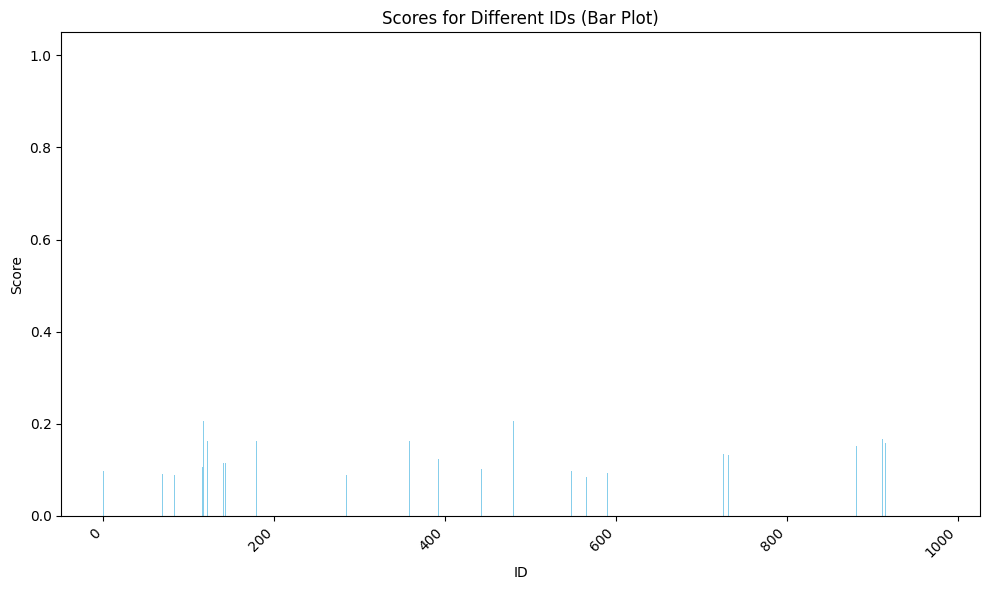

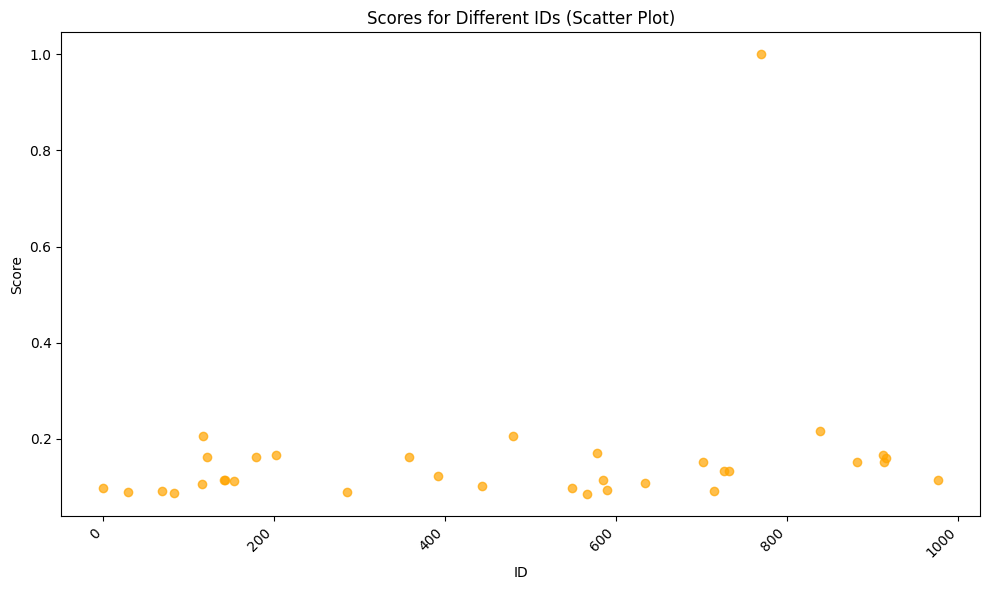

In [16]:
import matplotlib.pyplot as plt

# Extract IDs and scores from sorted recommendations
ids = [recommend[0] for recommend in sorted_recommendations]
scores = [recommend[1] for recommend in sorted_recommendations]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(ids, scores, color='skyblue')
plt.title('Scores for Different IDs (Bar Plot)')
plt.xlabel('ID')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ids, scores, color='orange', alpha=0.7)
plt.title('Scores for Different IDs (Scatter Plot)')
plt.xlabel('ID')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [32]:
complete_data = client.retrieve(
    collection_name=country_collection_name,
    ids= [data[0] for data in sorted_recommendations],
    with_vectors=True
)

# Extract vectors from complete_data
vector_data = [data.vector for data in complete_data]
vector_data[0][:5]


2024-03-20 23:28:51,348 : DEBUG : close.started
2024-03-20 23:28:51,350 : DEBUG : close.complete
2024-03-20 23:28:51,352 : DEBUG : connect_tcp.started host='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' port=6333 local_address=None timeout=5.0 socket_options=None
2024-03-20 23:28:51,630 : DEBUG : connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000002B4DBBE17D0>
2024-03-20 23:28:51,632 : DEBUG : start_tls.started ssl_context=<ssl.SSLContext object at 0x000002B4DA5F8710> server_hostname='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' timeout=5.0
2024-03-20 23:28:51,908 : DEBUG : start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000002B4DBADA9D0>
2024-03-20 23:28:51,910 : DEBUG : send_request_headers.started request=<Request [b'POST']>
2024-03-20 23:28:51,912 : DEBUG : send_request_headers.complete
2024-03-20 23:28:51,914 : DEBUG : send_request_body.started request=<Request [b'POST

[0.060385756, 0.07749039, -0.04740037, 0.111623615, -0.02930445]

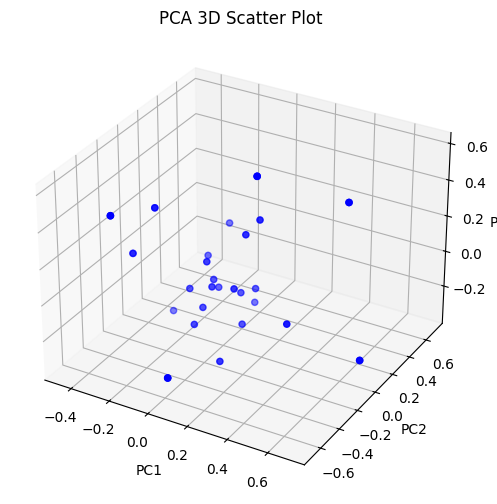

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vector_data)

# Create 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D scatter plot
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], c='b', marker='o')

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3D Scatter Plot')

plt.show()


In [37]:
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vector_data)

# Create interactive scatter plot with Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=vectors_3d[:, 0],
    y=vectors_3d[:, 1],
    z=vectors_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',                # set color to an array/list of desired values
        opacity=0.8
    )
)])

# Set layout options
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='PCA 3D Scatter Plot'
)

# Show the plot
fig.show()
